# Clustering Analysis

K-Means, DBSCAN, Anomaly?

In [22]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [2]:
# Parameters
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'rodents_per_year_merged.csv')  # construct the file path
rodents_df = pd.read_csv(file_path)
print(len(rodents_df))
rodents_df.head()

38958


,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [3]:
df = rodents_df.filter(regex='^(?!t_|d_|l_).*')
#df = df[df['year']==2019]
df = df.drop(['year','spatial_id','num_dsny_complaints','num_violations'], axis=1)

# K Means code here 

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
# calculate the correlation matrix
corr_matrix = df_scaled.corr()

# find the fields with the highest correlation to the target variable
target_var = 'num_sightings'
corr_values = corr_matrix[target_var]
highest_corr_fields = list(corr_values[corr_values.abs() > 0.05].index)

# create a new dataframe with only the selected fields
df_new = df_scaled[highest_corr_fields]
df_new.head()

,num_sightings,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Coffee/Tea_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
highest_corr_fields

['num_sightings',
 's_Illegal_Dumping:Street_sum',
 's_Trash:Residential_sum',
 's_Trash:Street_sum',
 's_Trash_Overflowing:Street_sum',
 's_Trash_Time:Street_sum',
 's_Trash_Unsecure:Residential_sum',
 's_Trash_Unsecure:Street_sum',
 'subway_count',
 'v_flies_sum',
 'v_rats/mice_sum',
 'v_roaches_sum',
 'c_American_sum',
 'c_Coffee/Tea_sum',
 'c_Mexican_sum',
 'c_Pizza_sum',
 'c_other_sum']

# K Means

In [7]:
# Range of k values to try
k_values = range(2, 11)

# Loop over k values and compute silhouette score for each, and inertia
for k in k_values:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_new)
    # Compute silhouette score
    score = silhouette_score(df_new, kmeans.labels_)
    # Compute Inertia 
    inertia = kmeans.inertia_
    print(f"For k={k}, silhouette score={score:.3f}, inertia:{inertia:.3f}")

For k=2, silhouette score=0.700, inertia:537.080
For k=3, silhouette score=0.476, inertia:486.568
For k=4, silhouette score=0.484, inertia:447.320
For k=5, silhouette score=0.491, inertia:412.757
For k=6, silhouette score=0.496, inertia:386.122
For k=7, silhouette score=0.500, inertia:357.351
For k=8, silhouette score=0.468, inertia:335.098
For k=9, silhouette score=0.474, inertia:317.963
For k=10, silhouette score=0.356, inertia:303.519


In [8]:
# Choosing k=7 for the number of clusters
clusters = 7

In [9]:
# Fit KMeans model
kmeans = KMeans(n_clusters=clusters, random_state=42).fit(df_new)

# Add cluster labels to original dataframe
rodents_df['cluster'] = kmeans.labels_

In [10]:
rodents_df.head()

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations,cluster
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
rodents_df['spatial_id'] = rodents_df['spatial_id'].astype(str)
rodents_joined_tracts_gdf = pd.merge(cb_gdf[['geometry','spatial_id']], rodents_df, how='left')


<AxesSubplot:>

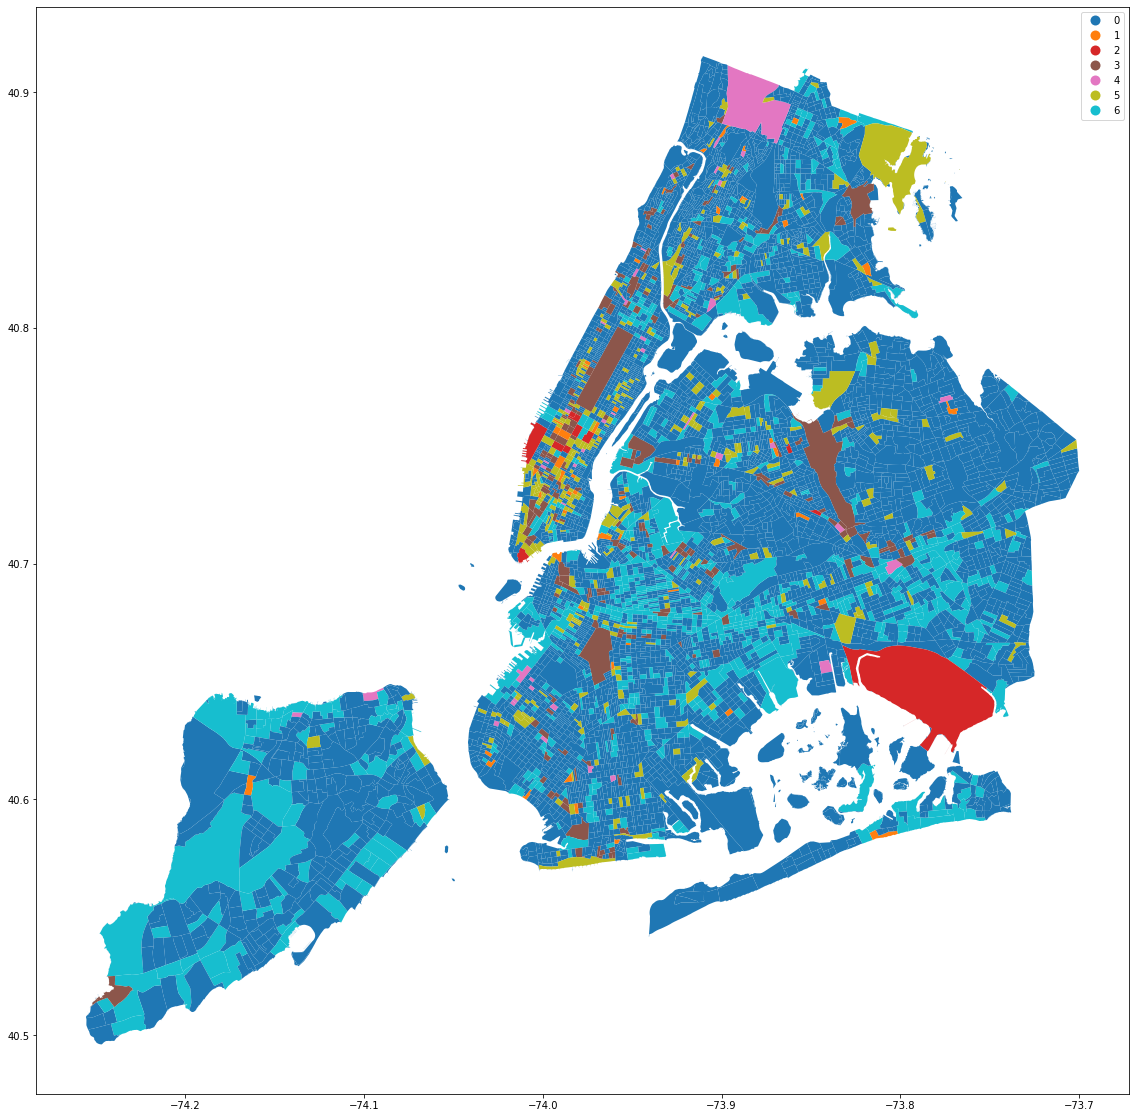

In [12]:
rodents_2019_df = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf['year']==2019]
rodents_2019_df.plot(column='cluster', cmap='tab10', categorical=True, figsize=(20, 20), legend=True)

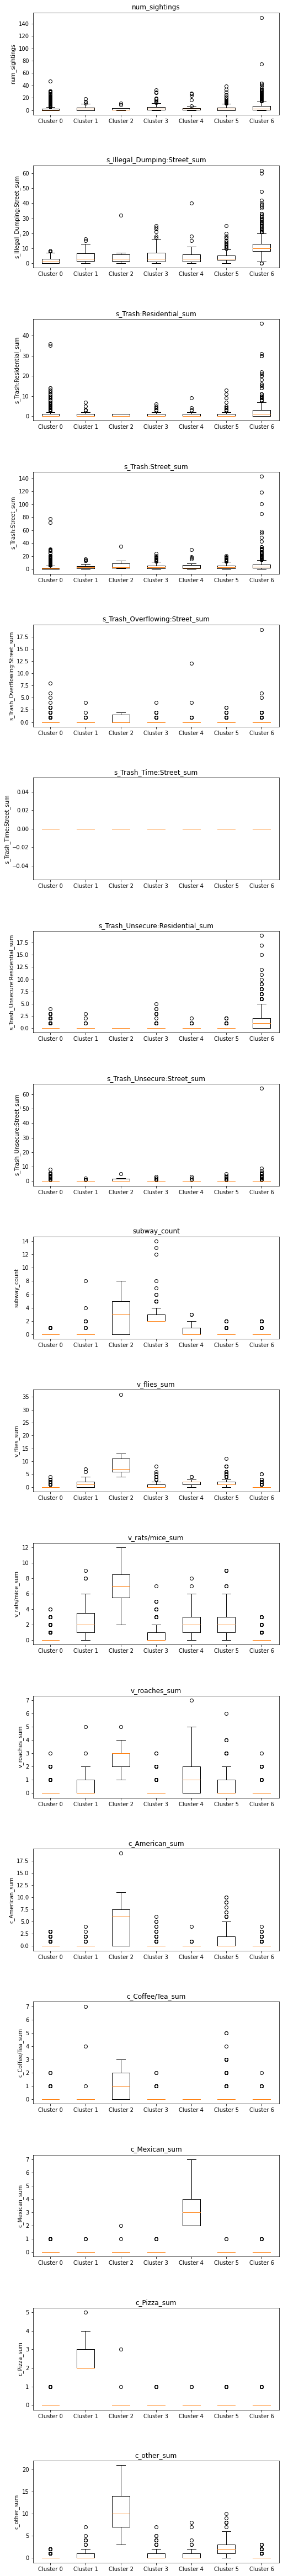

In [13]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(highest_corr_fields), figsize=(8, 5*len(highest_corr_fields)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(highest_corr_fields):
    # Create a list of dataframes for each cluster
    cluster_dfs = []
    for cluster_num in range(0, clusters):
        cluster_df = rodents_2019_df[rodents_2019_df['cluster'] == cluster_num]
        cluster_dfs.append(cluster_df)
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in cluster_dfs])
    cluster_labels = ['Cluster {}'.format(i) for i in range(clusters)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)
    
plt.show()

# DBSCAN 

<AxesSubplot:>

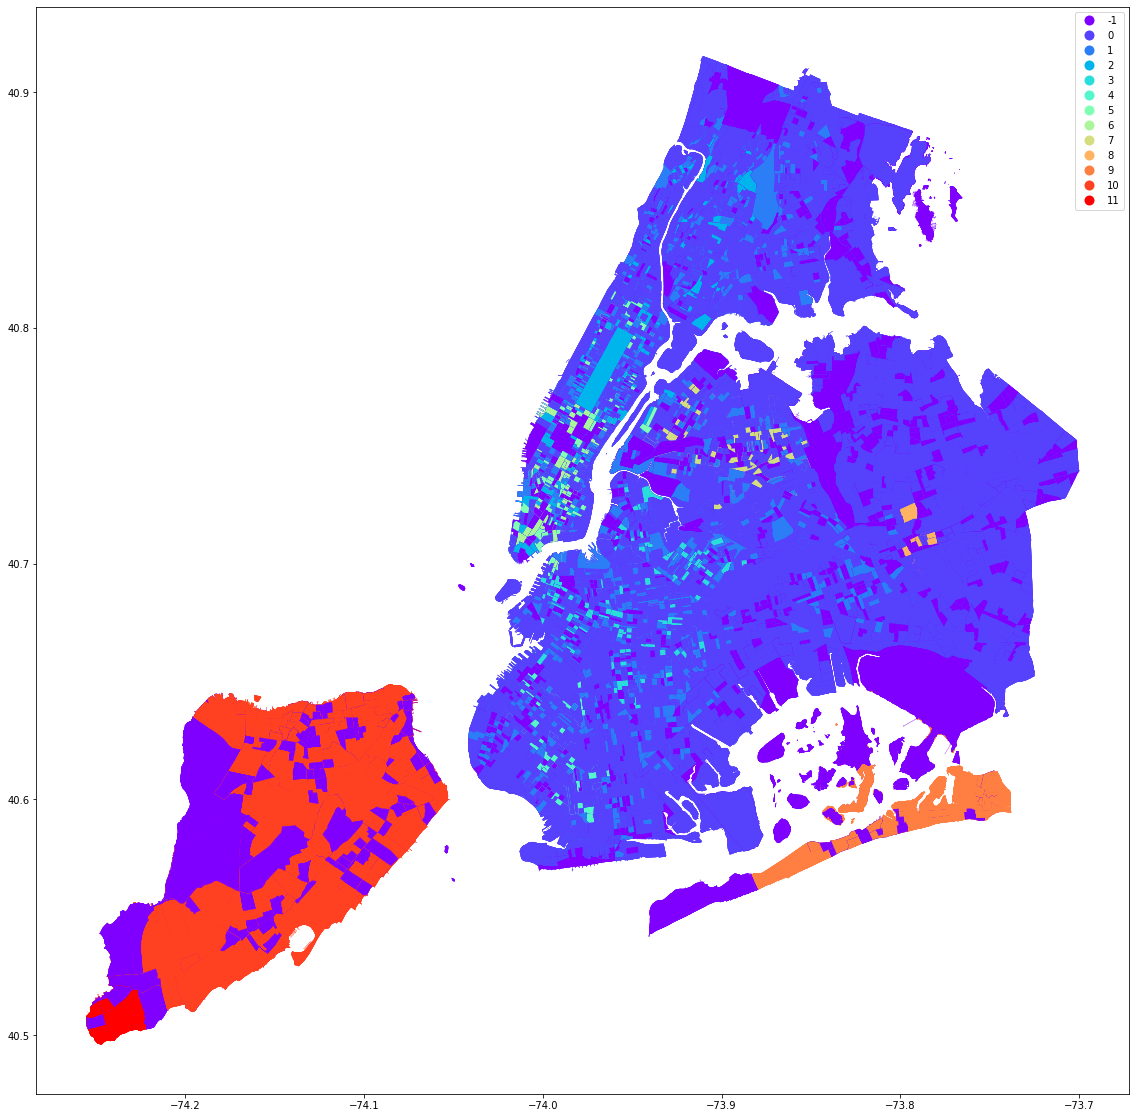

In [51]:
rodents_gdf = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf.geometry.notnull()]

# Choose columns for dbscan 
# cols = rodents_gdf.columns[3:-1] # (ALL COLUMNS)

# Cols gathered from pca notebook (ALL IMPORTANT COLUMNS ACROSS FIRST 5 PCAs)
#cols = ['l_Outdoor_sum', 'c_Italian_sum', 'l_Other_sum', 'c_Coffee/Tea_sum', 'subway_count', 'c_American_sum', 'l_Vacant_Space_sum', 'c_Caribbean_sum', 'l_Residential-Mixed_sum', 's_Trash_Unsecure:Street_sum', 'num_violations', 'v_flies_sum', 's_Dog_waste:Street_sum', 's_Trash_Unsecure:Residential_sum', 'v_rats/mice_sum', 's_Dead_Animal:Street_sum', 'c_Bakery Products/Desserts_sum', 's_Trash:Street_sum', 'c_Latin American_sum', 'v_roaches_sum', 's_Trash:Residential_sum', 's_Trash_Time:Street_sum', 'c_Chinese_sum', 's_Trash_Overflowing:Street_sum', 'c_other_sum', 'l_Residential_sum', 'c_Pizza_sum', 's_Illegal_Dumping:Street_sum', 's_Dead_Animal:Residential_sum', 's_Trash_MissedService:Street_sum']

# Cols gathered from pca notebook (ALL IMPORTANT COLUMNS FROM PCA 1)
#cols = ['num_violations', 'v_rats/mice_sum', 'v_flies_sum', 'c_other_sum', 'v_roaches_sum', 'c_American_sum', 'c_Coffee/Tea_sum', 'c_Chinese_sum', 'c_Italian_sum', 'c_Pizza_sum']

# Only num rodent violations as a weight
cols = ['num_violations']

# Extract the coordinates of the points
rodents_gdf['x'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.x), axis=1)
rodents_gdf['y'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.y), axis=1)

# Extract xy coordinates as features
X = rodents_gdf[['x', 'y']]

# Add additional variables to feature matrix
X = np.hstack((X, rodents_gdf[cols].values))

# Scale xy coordinates
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Scale features so that distances are not overfitting larger values

# Run DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=50) 
# TODO Show how these values were determined using one of the following:
'''
The silhouette score measures how well each data point fits into its assigned cluster compared to other clusters. 
A score close to 1 indicates that the data point is assigned to the correct cluster, 
while a score close to -1 indicates that the data point is assigned to the wrong cluster.

The Calinski-Harabasz index measures the ratio of between-cluster variance to within-cluster variance. 
A higher score indicates that the clusters are well-separated.

The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster. 
A lower score indicates that the clusters are well-separated.
'''
labels = dbscan.fit_predict(X)

rodents_gdf['dbscan_clusters'] = labels

rodents_gdf.plot(column='dbscan_clusters', cmap='rainbow', categorical=True, figsize=(20, 20), legend=True)

In [52]:
# TODO Describe these clusters

# Anomalies

In [ ]:
# TODO